In [9]:
import os
import joblib
import pandas as pd

LOGS_DIR = "../logs"

# Detect any Optuna study file
for file in os.listdir(LOGS_DIR):
    if file.startswith("hpo_study_") and file.endswith(".pkl"):
        pkl_path = os.path.join(LOGS_DIR, file)
        print(f"📦 Found study: {pkl_path}")
        
        # Load Optuna study
        study = joblib.load(pkl_path)
        
        # Export to CSV
        csv_name = file.replace(".pkl", ".csv")
        csv_path = os.path.join(LOGS_DIR, csv_name)
        df = study.trials_dataframe()
        df.to_csv(csv_path, index=False)
        
        print(f"✅ Exported → {csv_path}")

print("🎯 Done! You can now use your visualization script.")

import joblib, pandas as pd, os

LOGS_DIR = "../logs"

pkl = os.path.join(LOGS_DIR, "hpo_study_cuda.pkl")
if not os.path.exists(pkl):
    pkl = os.path.join(LOGS_DIR, "hpo_study_cpu.pkl")

print(f"📦 Loading {pkl}")
study = joblib.load(pkl)
df = study.trials_dataframe()
csv = pkl.replace(".pkl", ".csv").replace("hpo_study_", "hpo_trials_")
df.to_csv(csv, index=False)
print(f"✅ Saved CSV: {csv}")


📦 Found study: ../logs\hpo_study_cpu.pkl
✅ Exported → ../logs\hpo_study_cpu.csv
📦 Found study: ../logs\hpo_study_cuda.pkl
✅ Exported → ../logs\hpo_study_cuda.csv
🎯 Done! You can now use your visualization script.
📦 Loading ../logs\hpo_study_cuda.pkl
✅ Saved CSV: ../logs\hpo_trials_cuda.csv


✅ Loaded CUDA data (30 trials)
✅ Loaded CPU data (30 trials)

🌿 CUDA Best Trial:
Trial #: 25
Accuracy: 76.85%
CO₂: 12.962 g
Training Time: 472.05 s

🌿 CPU Best Trial:
Trial #: 21
Accuracy: 76.15%
CO₂: 10.432 g
Training Time: 376.39 s

✅ All GPU + CPU visualizations saved in ../results/figures/ (no warnings, with Sustainable Frontier 🌿)


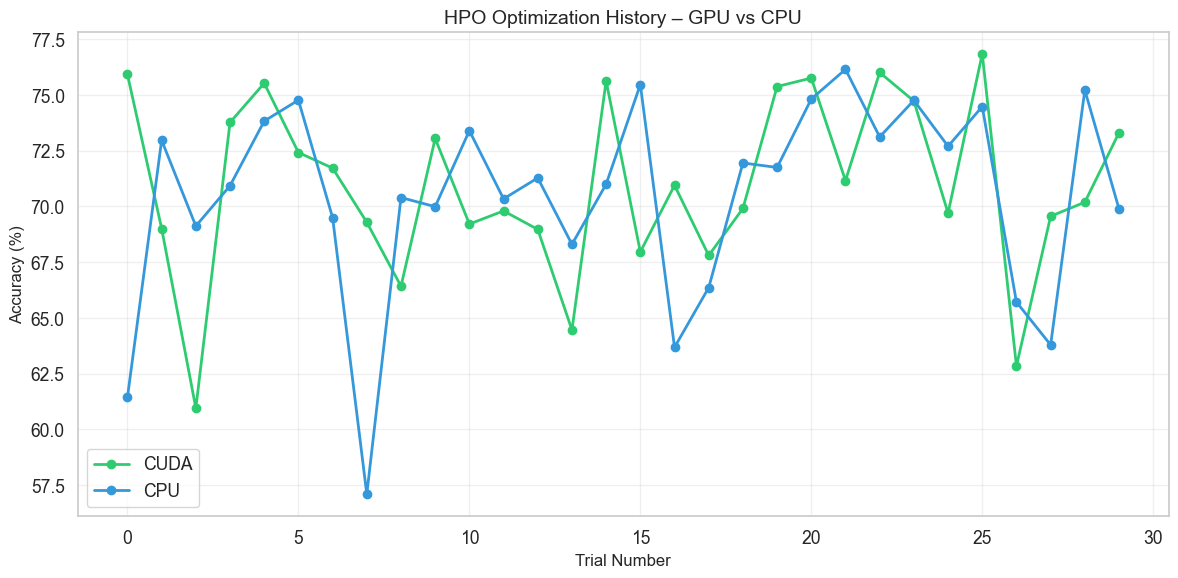

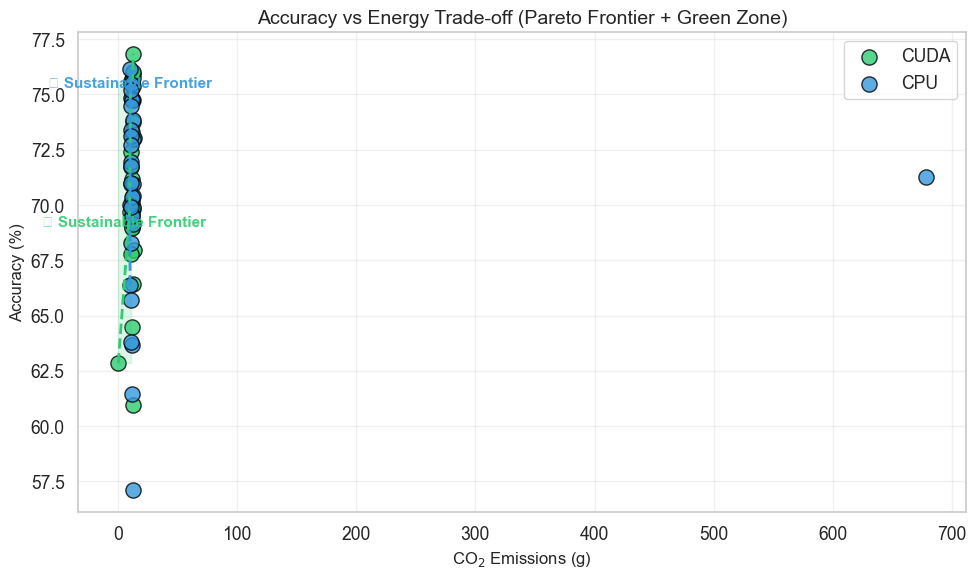

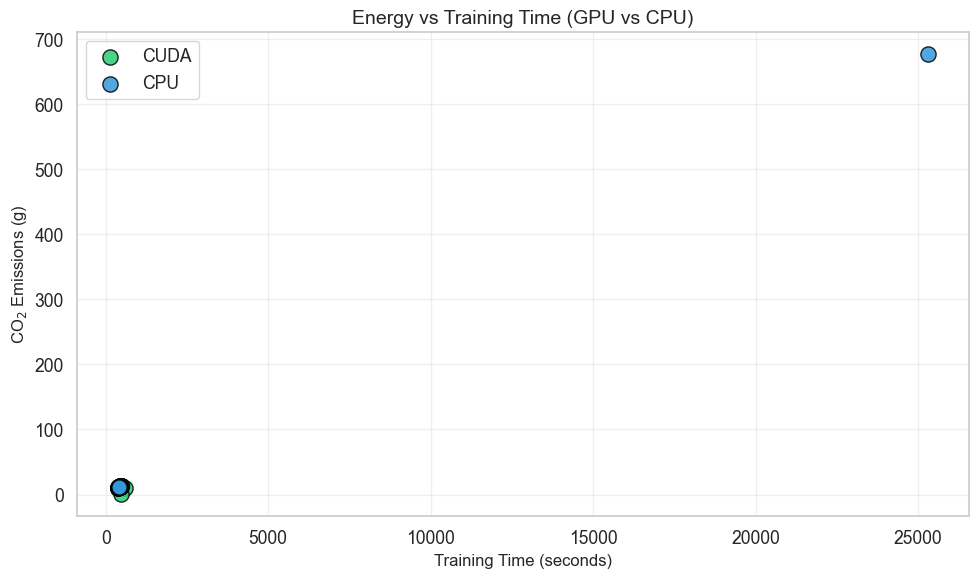

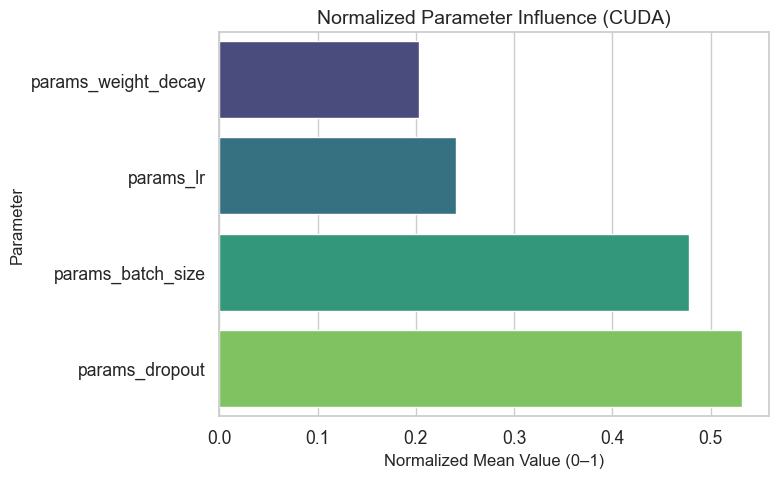

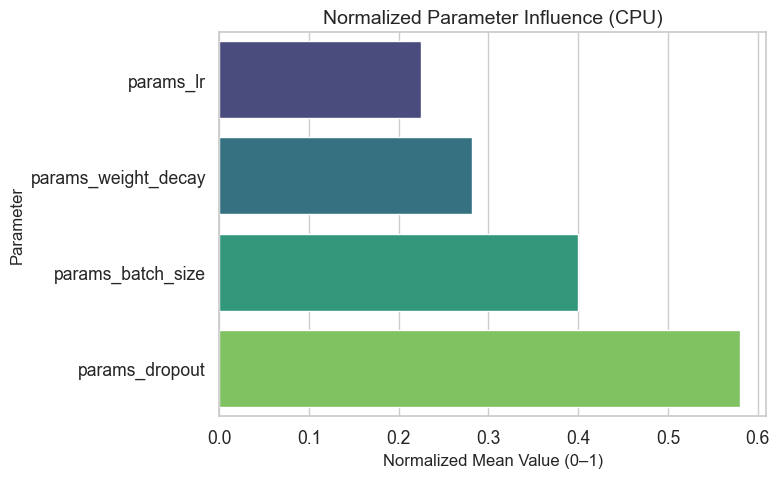

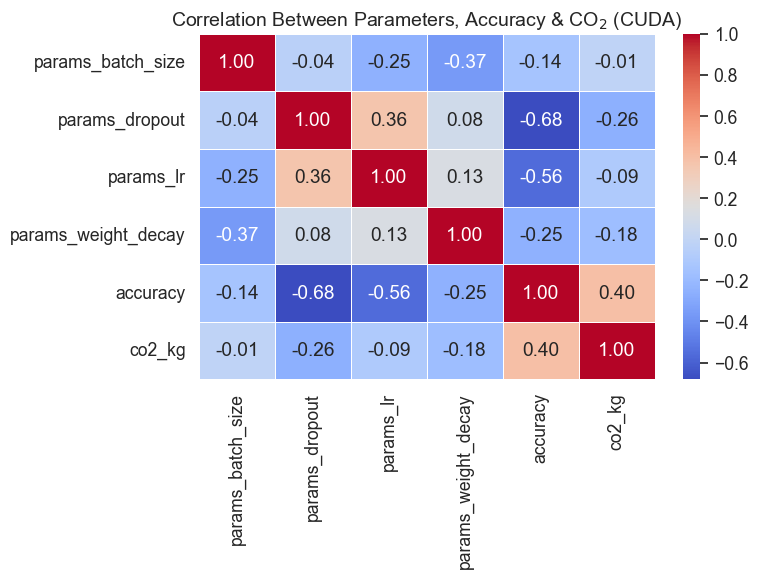

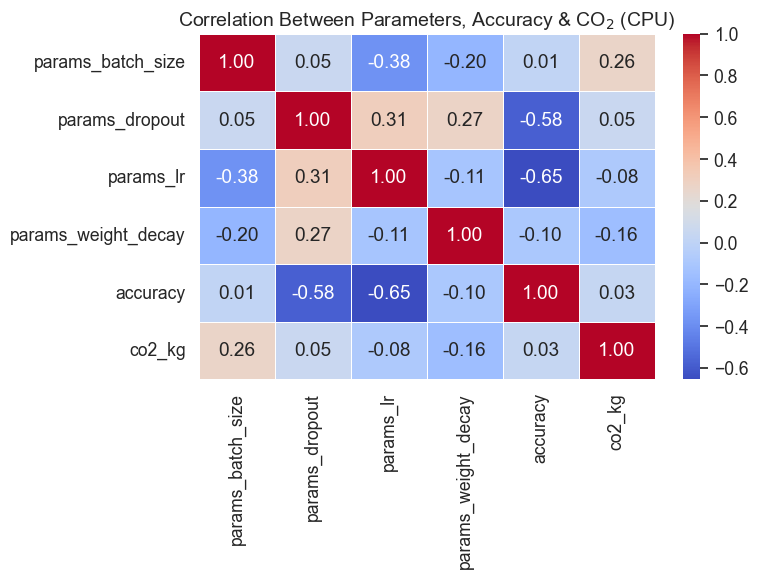

In [25]:
# 🌿 GREEN AI LIFECYCLE VISUALIZATION — FINAL STABLE VERSION
# ✅ GPU + CPU comparison, Pareto frontier, Green Zone, Sustainable Frontier label, no warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings

# ⚙️ Clean setup
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="Glyph.*missing from font.*")  # hide emoji font warning
plt.rcParams['font.family'] = 'DejaVu Sans'  # supports 🌿 emoji and clean typography

# 🌱 Paths
LOGS_DIR = "../logs"
RESULTS_DIR = "../results/figures"
os.makedirs(RESULTS_DIR, exist_ok=True)

# 🎨 Style
sns.set_theme(style="whitegrid", font_scale=1.15)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# 🌿 Load datasets (GPU + CPU)
datasets = {}
for device in ["cuda", "cpu"]:
    csv_path = os.path.join(LOGS_DIR, f"hpo_trials_{device}.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df.rename(columns={
            "number": "trial",
            "values_0": "accuracy",
            "values_1": "co2_kg",
            "user_attrs_training_time": "training_time"
        }, inplace=True)
        df["device"] = device.upper()
        df["accuracy"] = df["accuracy"].astype(float)
        df["co2_kg"] = df["co2_kg"].astype(float)
        if "training_time" in df.columns:
            df["training_time"] = df["training_time"].astype(float)
        datasets[device] = df
        print(f"✅ Loaded {device.upper()} data ({len(df)} trials)")
    else:
        print(f"⚠️ {device.upper()} file not found — skipping.")

if not datasets:
    raise FileNotFoundError("❌ No HPO log files found in ../logs/")

# 🎨 Colors
colors = {"CUDA": "#2ecc71", "CPU": "#3498db"}

# 1️⃣ Accuracy Progress (GPU vs CPU)
plt.figure(figsize=(12, 6))
for device, df in datasets.items():
    plt.plot(df["trial"], df["accuracy"], marker="o", linewidth=2,
             label=f"{device.upper()}", color=colors[device.upper()])
plt.xlabel("Trial Number")
plt.ylabel("Accuracy (%)")
plt.title("HPO Optimization History – GPU vs CPU")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/compare_accuracy_history.png", dpi=300)

# 2️⃣ Accuracy vs CO₂ (Pareto Frontier + Green Zone)
plt.figure(figsize=(10, 6))
for device, df in datasets.items():
    plt.scatter(df["co2_kg"] * 1000, df["accuracy"],
                s=120, alpha=0.8, edgecolors="black", linewidth=1,
                label=f"{device.upper()}", color=colors[device.upper()])

    # Pareto frontier (maximize accuracy, minimize CO₂)
    df_sorted = df.sort_values("co2_kg")
    pareto_points, max_acc = [], -np.inf
    for _, row in df_sorted.iterrows():
        if row["accuracy"] > max_acc:
            pareto_points.append(row)
            max_acc = row["accuracy"]
    pareto_df = pd.DataFrame(pareto_points)
    plt.plot(pareto_df["co2_kg"] * 1000, pareto_df["accuracy"],
             color=colors[device.upper()], linestyle="--", linewidth=2)

    # Green Zone (top 10% efficiency)
    df["efficiency"] = df["accuracy"] / (df["co2_kg"] + 1e-9)
    threshold = df["efficiency"].quantile(0.90)
    top_green = df[df["efficiency"] >= threshold]
    if not top_green.empty:
        plt.fill_betweenx(
            y=[top_green["accuracy"].min(), top_green["accuracy"].max()],
            x1=top_green["co2_kg"].min() * 1000,
            x2=top_green["co2_kg"].max() * 1000,
            color=colors[device.upper()], alpha=0.15
        )
        # 🌿 Add label for the sustainable frontier
        x_mid = (top_green["co2_kg"].min() * 1000 + top_green["co2_kg"].max() * 1000) / 2
        y_mid = (top_green["accuracy"].min() + top_green["accuracy"].max()) / 2
        plt.text(x_mid, y_mid, "🌿 Sustainable Frontier",
                 color=colors[device.upper()], fontsize=11,
                 ha="center", va="center", fontweight="bold", alpha=0.9)

plt.xlabel("CO$_2$ Emissions (g)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Energy Trade-off (Pareto Frontier + Green Zone)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/compare_accuracy_vs_co2_green_zone.png", dpi=300)

# 3️⃣ CO₂ vs Training Time
plt.figure(figsize=(10, 6))
for device, df in datasets.items():
    if "training_time" in df.columns:
        plt.scatter(df["training_time"], df["co2_kg"] * 1000,
                    s=120, alpha=0.85, edgecolors="black", linewidth=1,
                    label=f"{device.upper()}", color=colors[device.upper()])
plt.xlabel("Training Time (seconds)")
plt.ylabel("CO$_2$ Emissions (g)")
plt.title("Energy vs Training Time (GPU vs CPU)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/compare_energy_vs_time.png", dpi=300)

# 4️⃣ Parameter Influence
for device, df in datasets.items():
    params = [c for c in df.columns if c.startswith("params_")]
    if not params:
        continue
    norm_df = df[params].copy()
    for c in params:
        norm_df[c] = (norm_df[c] - norm_df[c].min()) / (norm_df[c].max() - norm_df[c].min() + 1e-9)
    imp = norm_df.mean().reset_index()
    imp.columns = ["param", "mean_value"]
    imp = imp.sort_values("mean_value", ascending=True)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=imp, x="mean_value", y="param", hue="param",
                palette="viridis", legend=False)
    plt.title(f"Normalized Parameter Influence ({device.upper()})")
    plt.xlabel("Normalized Mean Value (0–1)")
    plt.ylabel("Parameter")
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/hpo_param_influence_{device}.png", dpi=300)

# 5️⃣ Correlation Heatmap
for device, df in datasets.items():
    params = [c for c in df.columns if c.startswith("params_")]
    if not params:
        continue
    corr_cols = params + ["accuracy", "co2_kg"]
    corr = df[corr_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Between Parameters, Accuracy & CO$_2$ ({device.upper()})")
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/hpo_param_correlation_{device}.png", dpi=300)

# 🌟 Summary Output
for device, df in datasets.items():
    best_trial = df.loc[df["accuracy"].idxmax()]
    print(f"\n🌿 {device.upper()} Best Trial:")
    print(f"Trial #: {int(best_trial['trial'])}")
    print(f"Accuracy: {best_trial['accuracy']:.2f}%")
    print(f"CO₂: {best_trial['co2_kg'] * 1000:.3f} g")
    if 'training_time' in df.columns:
        print(f"Training Time: {best_trial['training_time']:.2f} s")

print("\n✅ All GPU + CPU visualizations saved in ../results/figures/ (no warnings, with Sustainable Frontier 🌿)")
